In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


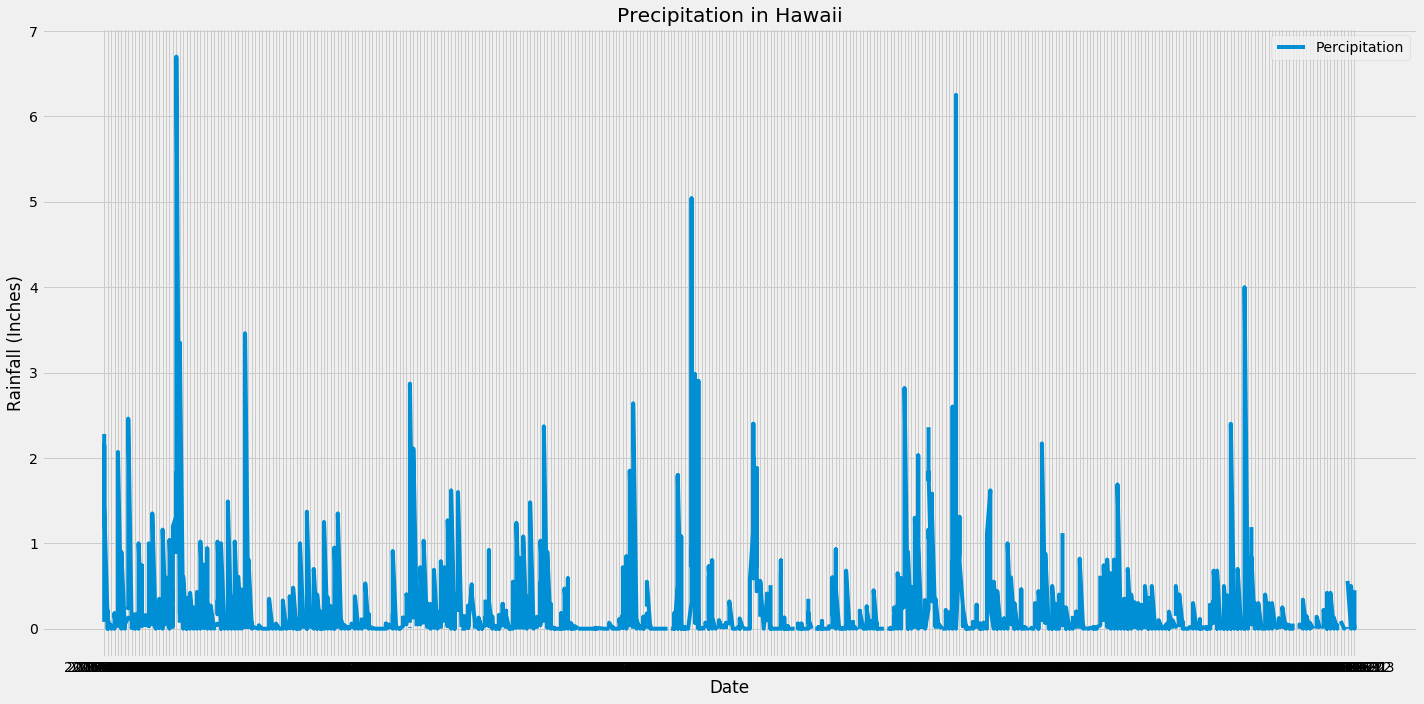

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24', Measurement.date <= '2017-08-23').\
        order_by(Measurement.date).all()
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data=precip_data)
precip_df.head(15)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by = "date")
precip_df.head(15)

# Use Pandas Plotting with Matplotlib to plot the data
df=pd.DataFrame(data=precip_data)
plt.figure(figsize = (20,10))
plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Percipitation'])
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

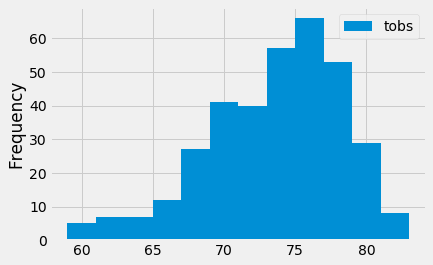

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(Measurement.tobs).\
                                filter(Measurement.station=='USC00519281').\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in histogram]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_stats = calc_temps('2017-05-17', '2017-05-24')
temp_stats

[(68.0, 74.53333333333333, 87.0)]

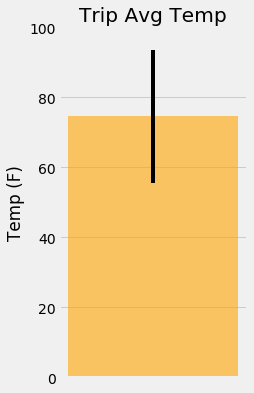

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = temp_stats[0][0]
avg_temp = temp_stats[0][1]
max_temp = temp_stats[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-05-17'
end_date = '2017-05-24'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"  {row[0]}\n    Rainfall:  {rain}, Location:  {row[2]}\n    Elevation:  {row[3]}, Latitude:  {row[4]}, Longitude:  {row[5]}")
    print()

  USC00516128
    Rainfall:  2.97, Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4, Latitude:  21.3331, Longitude:  -157.8025

  USC00519523
    Rainfall:  1.07, Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5, Latitude:  21.33556, Longitude:  -157.71139

  USC00513117
    Rainfall:  0.73, Location:  KANEOHE 838.1, HI US
    Elevation:  14.6, Latitude:  21.4234, Longitude:  -157.8015

  USC00519281
    Rainfall:  0.66, Location:  WAIHEE 837.5, HI US
    Elevation:  32.9, Latitude:  21.45167, Longitude:  -157.84888999999998

  USC00514830
    Rainfall:  0.39, Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0, Latitude:  21.5213, Longitude:  -157.8374

  USC00519397
    Rainfall:  0.22, Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0, Latitude:  21.2716, Longitude:  -157.8168



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
